In [9]:
# %pip install aiohttp
# %pip install mysql-connector-python
# %pip install nest_asyncio
# %pip install lenskit --upgrade
%pip install psycopg2

     |████████████████████████████████| 383 kB 2.1 MB/s eta 0:00:01
  Created wheel for psycopg2: filename=psycopg2-2.8.6-cp37-cp37m-macosx_10_9_x86_64.whl size=136235 sha256=322f8e72f39d5c2f98061fea840c4e3c61b150b2b23795367f1b08c5ce66cbc7
  Stored in directory: /Users/carlos/Library/Caches/pip/wheels/25/78/75/9c0323f7e1fb42143cbd2439302beb7850a1034abb961cb281
Successfully built psycopg2
Note: you may need to restart the kernel to use updated packages.


In [2]:
import asyncio
import aiohttp
import json
import sqlite3
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String
import urllib
from pandas.io import sql
from datetime import datetime
import numpy as np
import requests
from time import perf_counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nest_asyncio
nest_asyncio.apply()

# Performance Testing

In [5]:
class ConfigReader:
    def get_value(self, key):
        with open('config.json') as json_data_file:
            data = json.load(json_data_file)
        return data[key]

In [6]:
class DbManager:
    def __init__(self):
        reader = ConfigReader()
        db_connection = reader.get_value("db_connection")        
        self.conn_string = '{db_engine}{connector}://{user}:{password}@{server}/{database}'.format(
            db_engine=db_connection['db_engine'],
            connector=db_connection['connector'],
            user=db_connection['user'],
            password=db_connection['password'],
            server=db_connection['server'],
            database=db_connection['database'])

    def get_users(self):
        return sql.read_sql("SELECT distinct userId FROM ratings;", create_engine(self.conn_string))

In [15]:
reader = ConfigReader()
db_connection = reader.get_value("db_connection")        
conn_string = '{db_engine}{connector}://{user}:{password}@{server}/{database}'.format(
    db_engine=db_connection['db_engine'],
    connector=db_connection['connector'],
    user=db_connection['user'],
    password=db_connection['password'],
    server=db_connection['server'],
    database=db_connection['database'])

df = sql.read_sql("""SELECT 1 as "value"
       FROM information_schema.columns 
     WHERE table_schema='public' and table_name='rating' and column_name='rating';""", create_engine(conn_string))
len(df)



OperationalError: (psycopg2.OperationalError) could not connect to server: Connection refused
	Is the server running on host "localhost" (::1) and accepting
	TCP/IP connections on port 5432?
could not connect to server: Connection refused
	Is the server running on host "localhost" (127.0.0.1) and accepting
	TCP/IP connections on port 5432?

(Background on this error at: http://sqlalche.me/e/e3q8)

## Get random users

In [99]:
n_rand_users = num_requests = 100
dbManager = DbManager()
db_users = dbManager.get_users()
n_rand_users = db_users.sample(n=n_rand_users)

## Test recommendation endpoint

In [83]:
base_url = 'http://127.0.0.1:8000'
algo_rec = 'popular'
algo_pred = 'itemitem' # 'biasedmf'
n_recs = 5
items = "10,20,30,40,50"
pred_algos = ['bias','itemitem','useruser','biasedmf','implicitmf','funksvd']
rec_algos = ['popular']

### Semaphore performance

In [108]:
import os
throughputs = []

def print_stats(times, time_taken_all, num_requests):
    print(f'Total response time: {time_taken_all}')
    print(f'Throughput (requests per second): {num_requests / time_taken_all}')
    print(f'Peak response time: {max(times)}')
    print(f'Mean response time: {np.mean(times)}')
    print(f'99 percentile: {np.quantile(times, 0.99)}')

def plot_numbers(file_name):
    resp_time_per_request = np.genfromtxt(file_name, delimiter=',')
    plt.plot(resp_time_per_request)
    plt.show()
    
def hist_numbers(file_name):
    resp_time_per_request = np.genfromtxt(file_name, delimiter=',')
    plt.hist(resp_time_per_request, bins='auto')
    plt.show()

# Predictions    
async def get_preds_sem(num_sem, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds_with_sem(row['userId'], algo_pred, items, session, sem, times))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_preds_with_sem(userId, algo, items, session, sem, times):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem(userId, algo, items, session, times)        
        
async def get_user_preds_sem(userId, algo, items, session, times):
    url = f'{base_url}/algorithms/{algo}/predictions?user_id={userId}&items={items}'
    start = perf_counter()
    async with session.get(url) as resp:
        data = await resp.json()    
        time_taken = perf_counter() - start
        times.append(time_taken)
        
# Recommendations
async def get_recs_sem(num_sem, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_recs_with_sem(row['userId'], algo_pred, n_recs, session, sem, times))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_recs_with_sem(userId, algo, n_recs, session, sem, times):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_sem(userId, algo, n_recs, session, times)        
        
async def get_user_recs_sem(userId, algo, n_recs, session, times):
    url = f'{base_url}/algorithms/{algo}/recommendations?user_id={userId}&num_recs={n_recs}'
    start = perf_counter()
    async with session.get(url) as resp:
        data = await resp.json()    
        time_taken = perf_counter() - start
        times.append(time_taken)   

### Warm up phase

In [127]:
async def warm_up_async():
    num_workers = 24
    warm_up_user = 1
    times = []
    tasks = []
    async with aiohttp.ClientSession() as session:
        for algo in pred_algos:
            for w in range(num_workers):
                print(f'Calling {algo}. Worker number: {w + 1}')
                task = asyncio.ensure_future(get_user_preds_sem(warm_up_user, algo, items, session, times))
                tasks.append(task)
        responses = await asyncio.gather(*tasks)

In [128]:
def warm_up():
    loop = asyncio.get_event_loop()
    future = asyncio.ensure_future(warm_up_async())
    loop.run_until_complete(future)

In [129]:
warm_up()

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling bias. Worker number: 9
Calling bias. Worker number: 10
Calling bias. Worker number: 11
Calling bias. Worker number: 12
Calling bias. Worker number: 13
Calling bias. Worker number: 14
Calling bias. Worker number: 15
Calling bias. Worker number: 16
Calling bias. Worker number: 17
Calling bias. Worker number: 18
Calling bias. Worker number: 19
Calling bias. Worker number: 20
Calling bias. Worker number: 21
Calling bias. Worker number: 22
Calling bias. Worker number: 23
Calling bias. Worker number: 24
Calling itemitem. Worker number: 1
Calling itemitem. Worker number: 2
Calling itemitem. Worker number: 3
Calling itemitem. Worker number: 4
Calling itemitem. Worker number: 5
Calling itemitem. Worker number: 6
Calling itemitem. Worker number

### Call server using different semaphore numbers

#### Predictions

Number of requests: 100
Total response time: 34.24485102000108
Throughput (requests per second): 2.920147030033622
Peak response time: 2.702340144000118
Mean response time: 0.34215438240004004
99 percentile: 2.1593122235095716


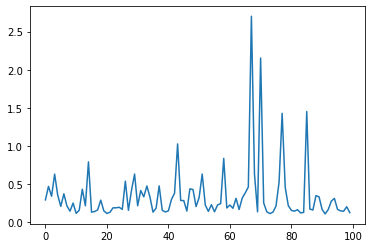

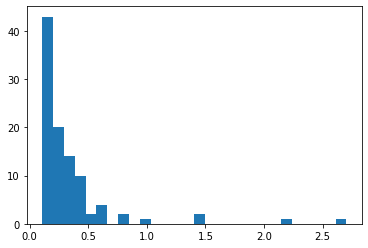

In [109]:
file_name = f'parallel_threads_1_workers_4_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(1, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

Number of requests: 100
Total response time: 17.54647643899989
Throughput (requests per second): 5.699149931762584
Peak response time: 2.847118916999534
Mean response time: 0.34973318977992673
99 percentile: 2.1968354023484826


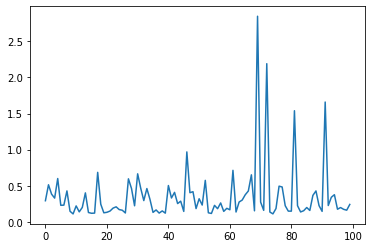

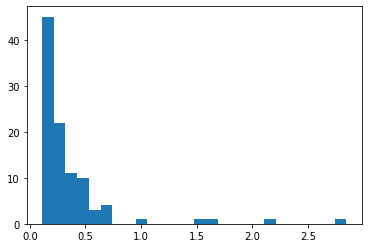

In [110]:
file_name = f'parallel_threads_2_workers_4_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(2, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

Number of requests: 100
Total response time: 12.247658537999087
Throughput (requests per second): 8.164825928951569
Peak response time: 3.7252561389996117
Mean response time: 0.48218467013004557
99 percentile: 2.855779393390844


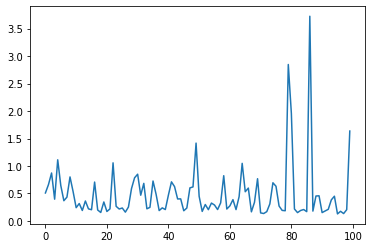

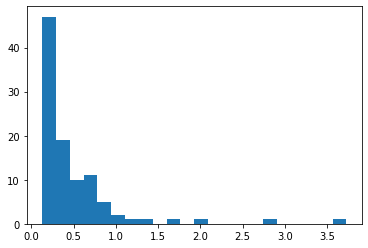

In [111]:
file_name = f'parallel_threads_4_workers_4_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

Number of requests: 100
Total response time: 10.742950103000112
Throughput (requests per second): 9.308430090545954
Peak response time: 4.115385506998791
Mean response time: 0.8317810770799224
99 percentile: 3.3479295384897383


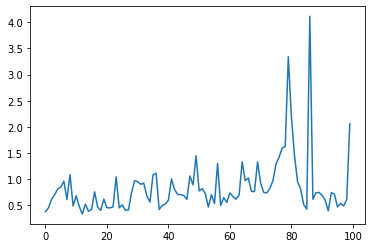

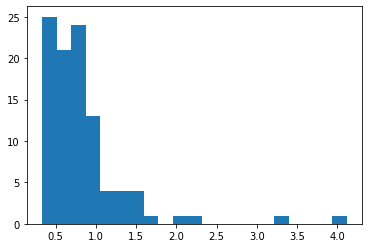

In [112]:
file_name = f'parallel_threads_8_workers_4_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(8, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

Number of requests: 100
Total response time: 11.478431253999588
Throughput (requests per second): 8.711991890455904
Peak response time: 4.837316893001116
Mean response time: 1.6969057542100745
99 percentile: 4.184818348390094


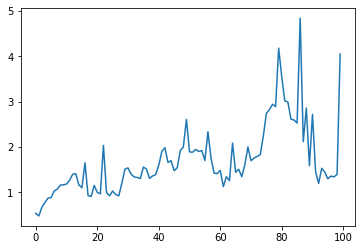

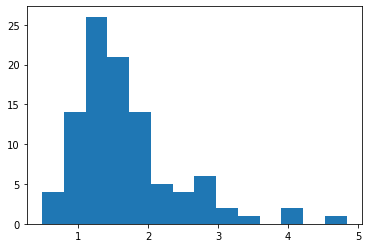

In [113]:
file_name = f'parallel_threads_16_workers_4_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(16, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

#### Throughputs

In [116]:
throughput_file_name = 'throughput_single_multiple_requests.csv'
np.savetxt(throughput_file_name, throughputs , delimiter=',')

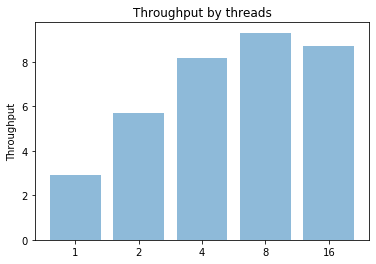

In [117]:
throughputs_from_file = np.genfromtxt(throughput_file_name, delimiter=',')
threads = [1, 2, 4, 8, 16]
y_pos = np.arange(len(throughputs_from_file))

plt.bar(y_pos, throughputs_from_file, align='center', alpha=0.5)
plt.xticks(y_pos, threads)
plt.ylabel('Throughput')
plt.title('Throughput by threads')

plt.show()

##### Boxplot for all prediction scenarios

([<matplotlib.axis.XTick at 0x23c54c890>,
 <a list of 5 Text xticklabel objects>)

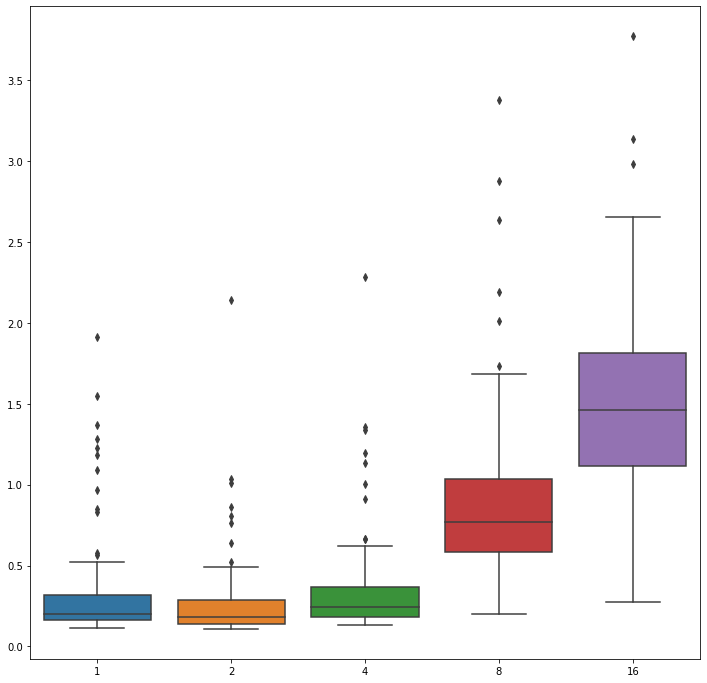

In [96]:
preds_scenarios = [np.genfromtxt(f'parallel_threads_1_workers_4_num_req_{num_requests}.csv', delimiter=','),
   np.genfromtxt(f'parallel_threads_2_workers_4_num_req_{num_requests}.csv', delimiter=','),
   np.genfromtxt(f'parallel_threads_4_workers_4_num_req_{num_requests}.csv', delimiter=','),
   np.genfromtxt(f'parallel_threads_8_workers_4_num_req_{num_requests}.csv', delimiter=','),
   np.genfromtxt(f'parallel_threads_16_workers_4_num_req_{num_requests}.csv', delimiter=',')
   ]

a4_dims = (12, 12)
fig, ax = plt.subplots(figsize=a4_dims)

sns.boxplot(ax=ax, data=preds_scenarios)
plt.xticks([0, 1, 2, 3, 4], [1, 2, 4, 8, 16])

#### Recommendations

Number of requests: 100
Total response time: 33.946418255000026
Throughput (requests per second): 2.9458188857751093
Peak response time: 2.783394658999896
Mean response time: 0.339166930650008
99 percentile: 2.0713902893293237


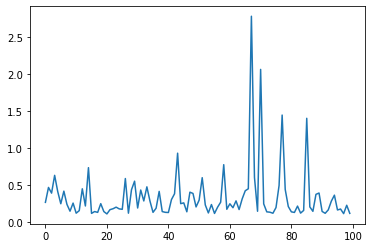

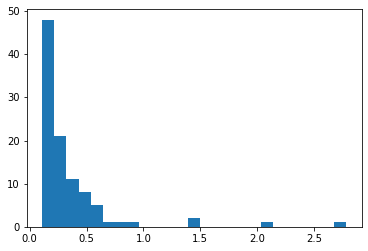

In [118]:
file_name = f'rec_parallel_threads_1_workers_4_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_recs_sem(1, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

### Call server using different workers in parallel - need to restart the server

In [151]:
throughputs = []

#### Four threads and one worker 

In [154]:
warm_up()

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling bias. Worker number: 9
Calling bias. Worker number: 10
Calling bias. Worker number: 11
Calling bias. Worker number: 12
Calling bias. Worker number: 13
Calling bias. Worker number: 14
Calling bias. Worker number: 15
Calling bias. Worker number: 16
Calling bias. Worker number: 17
Calling bias. Worker number: 18
Calling bias. Worker number: 19
Calling bias. Worker number: 20
Calling bias. Worker number: 21
Calling bias. Worker number: 22
Calling bias. Worker number: 23
Calling bias. Worker number: 24
Calling itemitem. Worker number: 1
Calling itemitem. Worker number: 2
Calling itemitem. Worker number: 3
Calling itemitem. Worker number: 4
Calling itemitem. Worker number: 5
Calling itemitem. Worker number: 6
Calling itemitem. Worker number

Number of requests: 100
Total response time: 32.79312975999892
Throughput (requests per second): 3.049419214691123
Peak response time: 5.122198969000237
Mean response time: 1.3016024677100178
99 percentile: 3.9223512350816296


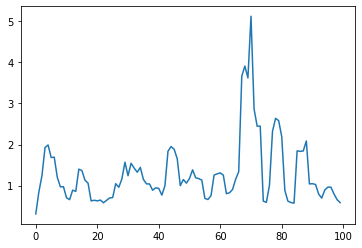

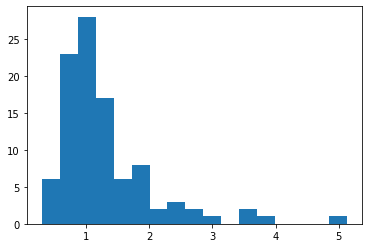

In [155]:
file_name = f'parallel_threads_4_workers_1_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

#### Four threads and two workers

In [157]:
warm_up()

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling bias. Worker number: 9
Calling bias. Worker number: 10
Calling bias. Worker number: 11
Calling bias. Worker number: 12
Calling bias. Worker number: 13
Calling bias. Worker number: 14
Calling bias. Worker number: 15
Calling bias. Worker number: 16
Calling bias. Worker number: 17
Calling bias. Worker number: 18
Calling bias. Worker number: 19
Calling bias. Worker number: 20
Calling bias. Worker number: 21
Calling bias. Worker number: 22
Calling bias. Worker number: 23
Calling bias. Worker number: 24
Calling itemitem. Worker number: 1
Calling itemitem. Worker number: 2
Calling itemitem. Worker number: 3
Calling itemitem. Worker number: 4
Calling itemitem. Worker number: 5
Calling itemitem. Worker number: 6
Calling itemitem. Worker number

Number of requests: 100
Total response time: 15.751016999000058
Throughput (requests per second): 6.348796398756248
Peak response time: 2.8989340830012225
Mean response time: 0.6242433417799657
99 percentile: 2.5674879497389718


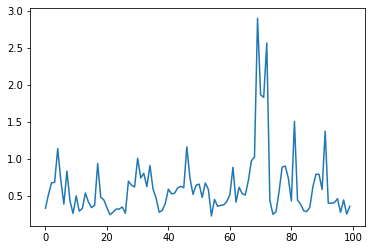

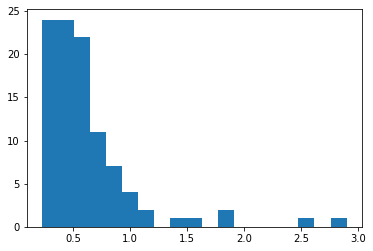

In [158]:
file_name = f'parallel_threads_4_workers_2_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

#### Four threads and four workers

In [159]:
warm_up()

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling bias. Worker number: 9
Calling bias. Worker number: 10
Calling bias. Worker number: 11
Calling bias. Worker number: 12
Calling bias. Worker number: 13
Calling bias. Worker number: 14
Calling bias. Worker number: 15
Calling bias. Worker number: 16
Calling bias. Worker number: 17
Calling bias. Worker number: 18
Calling bias. Worker number: 19
Calling bias. Worker number: 20
Calling bias. Worker number: 21
Calling bias. Worker number: 22
Calling bias. Worker number: 23
Calling bias. Worker number: 24
Calling itemitem. Worker number: 1
Calling itemitem. Worker number: 2
Calling itemitem. Worker number: 3
Calling itemitem. Worker number: 4
Calling itemitem. Worker number: 5
Calling itemitem. Worker number: 6
Calling itemitem. Worker number

Number of requests: 100
Total response time: 11.157750522999777
Throughput (requests per second): 8.962379988140734
Peak response time: 3.2887468640001316
Mean response time: 0.4359336257099494
99 percentile: 2.472866628498891


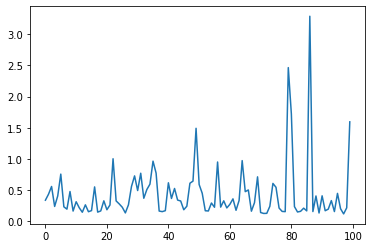

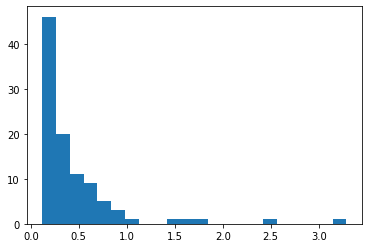

In [160]:
file_name = f'parallel_threads_4_workers_4_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

#### Four threads and eight workers

In [161]:
warm_up()

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling bias. Worker number: 9
Calling bias. Worker number: 10
Calling bias. Worker number: 11
Calling bias. Worker number: 12
Calling bias. Worker number: 13
Calling bias. Worker number: 14
Calling bias. Worker number: 15
Calling bias. Worker number: 16
Calling bias. Worker number: 17
Calling bias. Worker number: 18
Calling bias. Worker number: 19
Calling bias. Worker number: 20
Calling bias. Worker number: 21
Calling bias. Worker number: 22
Calling bias. Worker number: 23
Calling bias. Worker number: 24
Calling itemitem. Worker number: 1
Calling itemitem. Worker number: 2
Calling itemitem. Worker number: 3
Calling itemitem. Worker number: 4
Calling itemitem. Worker number: 5
Calling itemitem. Worker number: 6
Calling itemitem. Worker number

Number of requests: 100
Total response time: 11.212265358000877
Throughput (requests per second): 8.91880425650484
Peak response time: 4.111176095999326
Mean response time: 0.43869317695987775
99 percentile: 2.9562066153899713


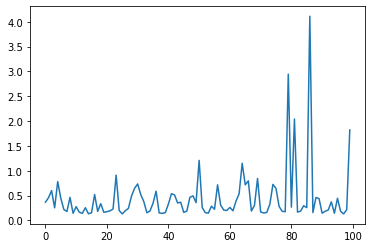

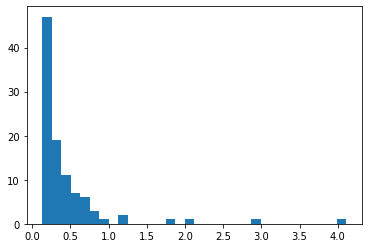

In [162]:
file_name = f'parallel_threads_4_workers_8_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

#### Four threads and sixteen workers

In [164]:
warm_up()

Calling bias. Worker number: 1
Calling bias. Worker number: 2
Calling bias. Worker number: 3
Calling bias. Worker number: 4
Calling bias. Worker number: 5
Calling bias. Worker number: 6
Calling bias. Worker number: 7
Calling bias. Worker number: 8
Calling bias. Worker number: 9
Calling bias. Worker number: 10
Calling bias. Worker number: 11
Calling bias. Worker number: 12
Calling bias. Worker number: 13
Calling bias. Worker number: 14
Calling bias. Worker number: 15
Calling bias. Worker number: 16
Calling bias. Worker number: 17
Calling bias. Worker number: 18
Calling bias. Worker number: 19
Calling bias. Worker number: 20
Calling bias. Worker number: 21
Calling bias. Worker number: 22
Calling bias. Worker number: 23
Calling bias. Worker number: 24
Calling itemitem. Worker number: 1
Calling itemitem. Worker number: 2
Calling itemitem. Worker number: 3
Calling itemitem. Worker number: 4
Calling itemitem. Worker number: 5
Calling itemitem. Worker number: 6
Calling itemitem. Worker number

Number of requests: 100
Total response time: 10.658345214998917
Throughput (requests per second): 9.382319486075133
Peak response time: 3.4114767520004534
Mean response time: 0.41457473721005955
99 percentile: 2.5461880142802373


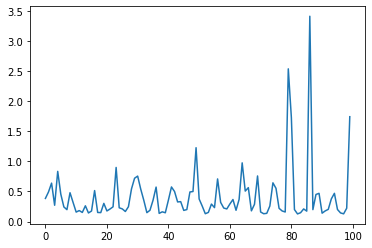

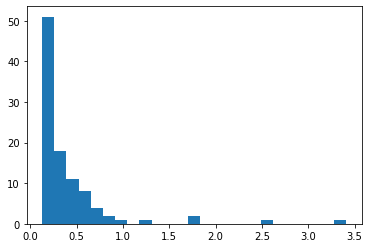

In [165]:
file_name = f'parallel_threads_4_workers_16_num_req_{num_requests}.csv'
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_sem(4, file_name, True))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)

#### Throughput by number of workers

In [166]:
throughput_file_name_workers = 'throughput_single_multiple_workers.csv'
np.savetxt(throughput_file_name_workers, throughputs , delimiter=',')

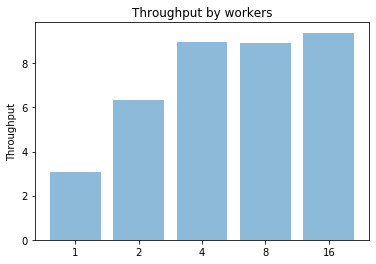

In [167]:
throughputs_workers_from_file = np.genfromtxt(throughput_file_name_workers, delimiter=',')
workers = [1, 2, 4, 8, 16]
y_pos = np.arange(len(throughputs_workers_from_file))

plt.bar(y_pos, throughputs_workers_from_file, align='center', alpha=0.5)
plt.xticks(y_pos, workers)
plt.ylabel('Throughput')
plt.title('Throughput by workers')

plt.show()

### Lenskit

In [168]:
import sys
import math
from binpickle import BinPickleFile
from pathlib import Path

directory_path = 'models'
algo_pred_lkpy = 'bias.bpk'

def load_for_shared_mem(file_name):
    full_file_name = Path(directory_path) / file_name

    binpickle_file = BinPickleFile(full_file_name, direct=True)
    model = binpickle_file.load()
    return model

def get_predictions_from_model(model, user, items):
    try:
        results = []
        df_preds = model.predict_for_user(user, items)
        for index, value in df_preds.iteritems():
            if not math.isnan(value):
                results.append({'item': index, 'score': value})
        return results
    except:
        print(f"Unexpected preds error for user: {user}, with items: {items}. Error: {sys.exc_info()[0]}")
        raise
        

# Predictions    
async def get_preds_threads_lkpy(num_sem, model, file_name=None, add_throughput=False):
    times = []
    sem = asyncio.Semaphore(num_sem)
    tasks = []    
    num_requests = len(n_rand_users)
    print(f'Number of requests: {num_requests}')
    start_preds = perf_counter()

    async with aiohttp.ClientSession() as session:
        for idx, row in n_rand_users.iterrows():
            task = asyncio.ensure_future(get_user_preds_with_threads_lkpy(row['userId'], algo_pred_lkpy, items, session, sem, times, model))
            tasks.append(task)         

        responses = await asyncio.gather(*tasks)
        time_taken_all = perf_counter() - start_preds
        print_stats(times, time_taken_all, num_requests)
        
        if file_name != None and file_name != '':
            if os.path.exists(file_name):
                os.remove(file_name)
            np.asarray(times)
            np.savetxt(file_name, times, delimiter=',')
        
        if add_throughput:
            throughputs.append(num_requests / time_taken_all)

async def get_user_preds_with_threads_lkpy(userId, algo, items, session, sem, times, model):
    async with sem:  # semaphore limits num of simultaneous downloads
        return await get_user_preds_threads_lkpy(userId, algo, items, session, times, model)        
        
async def get_user_preds_threads_lkpy(userId, algo, items, session, times, model):
    try:
        start = perf_counter()
        results = []
        df_preds = model.predict_for_user(userId, items.split(','))
        for index, value in df_preds.iteritems():
            if not math.isnan(value):
                results.append({'item': index, 'score': value})
                
        time_taken = perf_counter() - start
        times.append(time_taken)
        return results
    except:
        print(f"Unexpected preds error for user: {userId}, with items: {items}. Error: {sys.exc_info()[0]}")
        raise
    
    
#     url = f'{base_url}/algorithms/{algo}/predictions?user_id={userId}&items={items}'
#     start = perf_counter()
#     async with session.get(url) as resp:
#         data = await resp.json()    
#         time_taken = perf_counter() - start
#         times.append(time_taken)        
        
        

Number of requests: 100
Total response time: 1.1792580950004776
Throughput (requests per second): 84.79907869528722
Peak response time: 0.019570094000300742
Mean response time: 0.01157792526000776
99 percentile: 0.0166063636704712


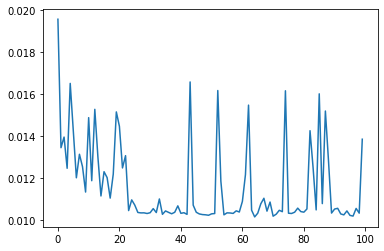

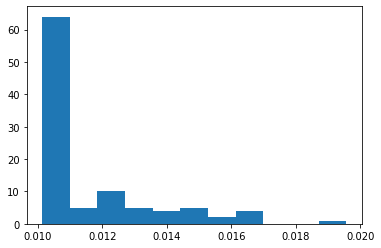

In [169]:
file_name = f'lkpy_parallel_threads_2_workers_4_num_req_{num_requests}.csv'
model = load_for_shared_mem('bias.bpk')
loop = asyncio.get_event_loop()
future = asyncio.ensure_future(get_preds_threads_lkpy(1, model, file_name))
loop.run_until_complete(future)
plot_numbers(file_name)
hist_numbers(file_name)